In [2]:
include("../source/spin-1_XY_ED.jl")

odlro_matrix (generic function with 1 method)

### 1) \$|E_{n}-E_{\mathcal{S}{}_n}|<C\$

#### I) Scar State

In [4]:
J1,J3,D,h = 1.0,0.1,0.1,1.0
n = 2
boundary = "OBC"
use_sparse = false

N_start::Int64,N_step::Int64,N_max::Int64 = 12,2,16
N_list::Vector{Int64} = Vector{Int64}(collect(N_start:N_step:N_max))
H_size_list::Vector{Int64} = Vector{Int64}(undef,length(N_list))
avg_mat_elem_list::Vector{Float64} = Vector{Float64}(undef,length(N_list))
std_mat_elem_list::Vector{Float64} = Vector{Float64}(undef,length(N_list))
energy_diff_cutoff::Int64 = 3

@time begin
    for (i,N) in enumerate(N_list)
        mz::Int64 = (2*n-N)
        nearest_bond_list = gen_bonds_1D(N,boundary)
        third_nbr_bond_list = gen_3rd_nbr_bonds_1D(N,boundary)
        sec_nbr_bond_list = gen_2nd_nbr_bonds_1D(N,boundary)
        basis_list = gen_basis_mz_1D_op(N,mz)
        basis_new1 = similar(basis_list[1])
        basis_new2 = similar(basis_list[1])
        H_XY,H_size = Ham_XY_1D(J1,J3,D,h,N,basis_list,basis_new1,basis_new2,nearest_bond_list,
                                  third_nbr_bond_list,use_sparse)
        
        basis_new = similar(basis_list[1])
        H_sec_nbr,H_size_sec_nbr = Ham_2nd_nbr_1D(N,basis_list,basis_new,sec_nbr_bond_list,use_sparse)
#         Hp_diag_matrix,H_size1 = Hp_diag(basis_list,nearest_bond_list,use_sparse)
        XY_energy,XY_eigenvector = eigen(H_XY)

        scar_state::Vector{Float64} = scar_state_1D(N,n,basis_list)
        scar_energy::Float64 = (mz*h+N*D)
        scar_eigenspec_overlap_list::Vector{Float64} = Vector{Float64}(undef,H_size)
        for (j,E) in enumerate(XY_energy)
            @views scar_eigenspec_overlap_list[j] = abs2(dot(XY_eigenvector[:,j],scar_state))
        end
        scar_max_overlap,scar_max_index = findmax(scar_eigenspec_overlap_list)
        
        energy_diff_list::Vector{Float64} = Vector{Float64}(undef,0)
        pert_matrix_element_list::Vector{Float64} = Vector{Float64}(undef,0)

        scar_outvect::Vector{Float64} =  H_sec_nbr*scar_state
        for (j::Int64,E::Float64) in enumerate(XY_energy)
            if (j != scar_max_index) && (abs(E-scar_energy) < energy_diff_cutoff)
                push!(energy_diff_list,E-scar_energy)
                @views push!(pert_matrix_element_list,abs(dot(XY_eigenvector[:,j],scar_outvect)))
            end
        end        
        averaged_mat_elem::Float64 = sum(pert_matrix_element_list)/length(pert_matrix_element_list)
        avg_sq_mat_elem::Float64 = sum(pert_matrix_element_list.^2)/length(pert_matrix_element_list)
        std_mat_elem::Float64 = sqrt(avg_sq_mat_elem-(averaged_mat_elem)^2)
        
        H_size_list[i] = H_size
        avg_mat_elem_list[i] = averaged_mat_elem
        std_mat_elem_list[i] = std_mat_elem
        println(H_size," ",length(energy_diff_list))
    end
end

pert_folder = "D:\\IACS_Project\\spin-1_XY\\data\\1D\\scar_matrix_element_scaling\\$(boundary)"
if !isdir(pert_folder)
    mkpath(pert_folder)
end

pert_file = joinpath(pert_folder,"Sn=$(n)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6))_Nmax=$(N_max)_Nstep=$(N_step)_Ediffcutoff=$(energy_diff_cutoff).jld2")
# @save pert_file N_vals=N_list H_size_vals=H_size_list matrix_element_vals=mat_elem_list;

1221 996
2184 1745
3620 2852
 16.096630 seconds (1.13 M allocations: 845.624 MiB, 1.54% gc time)


"D:\\IACS_Project\\spin-1_XY\\data\\1D\\scar_matrix_element_scaling\\OBC\\Sn=2_J1=1.0_J3=0.1_D=0.1_h=1.0_Nmax=16_Nstep=2_Ediffcutoff=3.jld2"

In [ ]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

plot_size = (700,466.67)

inv_root_H_size_list = 1 ./sqrt.(H_size_list)

p = plot(N_list,avg_mat_elem_list,m=:circle,ms=4.5,msw=1,msc=:black,
              lw=2,ls=:solid,label="\$S_{$n}\$",size=plot_size,dpi=200)
plot!(N_list,inv_root_H_size_list,m=:star,ms=4.5,msw=1,msc=:black,lw=2,ls=:dash,label="\$\\frac{1}{\\sqrt{D_L}}\$")
plot!(N_list,std_mat_elem_list,m=:circle,ms=4.5,msw=1,msc=:navy,lw=2,ls=:solid,label="\$\\mathrm{std}\$")

plot!(left_margin=5mm,right_margin=4mm,top_margin=1.2mm,bottom_margin=6mm)
plot!(framestyle=:axis)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)
plot!(legend_position=(0.85,0.9),legendfontsize=14,legend_background_color=:white,
    legend_foreground_color=:black,legend_columns=1)

xlabel!("\n\$L\$",guidefontsize=20)
# ylabel!("\$|\\langle n^{(0)}|H_p|S_{$n}\\rangle|\$\n",guidefontsize=20)
# title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = -4,2,4
y1,y_step,y2 = 0.0,0.5,1.5
xticks = (x1:x_step:x2,[@sprintf("%.1f",x) for x in x1:x_step:x2])
yticks = (y1:y_step:y2,[@sprintf("%.2f",y) for y in y1:y_step:y2])
xminor_ticks = 4
yminor_ticks = 2
# plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
#       xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:out)
# plot!(xlims=(-0.1,0.1))

# folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)\\scar_perturbation_matrix_element"
# if !isdir(folder_name)
#     mkpath(folder_name)
# end

# file_path = joinpath(folder_name,"Sn=$(n)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)

### 2) \$N\$ no. of states with smallest \$|E_{n}-E_{\mathcal{S}{}_n}|\$

In [3]:
J1,J3,D,h = 1.0,0.1,0.1,1.0
n = 2
boundary = "OBC"
use_sparse = false

N_start::Int64,N_step::Int64,N_max::Int64 = 12,2,18
N_list::Vector{Int64} = Vector{Int64}(collect(N_start:N_step:N_max))
H_size_list::Vector{Int64} = Vector{Int64}(undef,length(N_list))
avg_mat_elem_list::Vector{Float64} = Vector{Float64}(undef,length(N_list))
std_mat_elem_list::Vector{Float64} = Vector{Float64}(undef,length(N_list))
num_energy::Int64 = 1000

@time begin
    for (i,N) in enumerate(N_list)
        mz::Int64 = (2*n-N)
        nearest_bond_list = gen_bonds_1D(N,boundary)
        third_nbr_bond_list = gen_3rd_nbr_bonds_1D(N,boundary)
        sec_nbr_bond_list = gen_2nd_nbr_bonds_1D(N,boundary)
        basis_list = gen_basis_mz_1D_op(N,mz)
        basis_new1 = similar(basis_list[1])
        basis_new2 = similar(basis_list[1])
        H_XY,H_size = Ham_XY_1D(J1,J3,D,h,N,basis_list,basis_new1,basis_new2,nearest_bond_list,
                                  third_nbr_bond_list,use_sparse)
        
        basis_new = similar(basis_list[1])
        H_sec_nbr,H_size_sec_nbr = Ham_2nd_nbr_1D(N,basis_list,basis_new,sec_nbr_bond_list,use_sparse)
#         Hp_diag_matrix,H_size1 = Hp_diag(basis_list,nearest_bond_list,use_sparse)
        XY_energy,XY_eigenvector = eigen(H_XY)

        scar_state::Vector{Float64} = scar_state_1D(N,n,basis_list)
        scar_energy::Float64 = (mz*h+N*D)
        scar_eigenspec_overlap_list::Vector{Float64} = Vector{Float64}(undef,H_size)
        for (j,E) in enumerate(XY_energy)
            @views scar_eigenspec_overlap_list[j] = abs2(dot(XY_eigenvector[:,j],scar_state))
        end
        scar_max_overlap,scar_max_index = findmax(scar_eigenspec_overlap_list)
        println(scar_max_overlap)
        
        pert_matrix_element_list::Vector{Float64} = Vector{Float64}(undef,0)
        scar_outvect::Vector{Float64} =  H_sec_nbr*scar_state
        
        E_rest_idx = [1:scar_max_index-1;scar_max_index+1:length(XY_energy)]
        energy_diff_list = abs.(XY_energy[E_rest_idx].-scar_energy)
        idx_sub = partialsortperm(energy_diff_list,1:num_energy)
        idx = E_rest_idx[idx_sub]
        eigvec_sel = @views XY_eigenvector[:,idx]
        
        for j in 1:num_energy
            @views push!(pert_matrix_element_list,abs(dot(eigvec_sel[:,j],scar_outvect)))
        end
        averaged_mat_elem::Float64 = sum(pert_matrix_element_list)/length(pert_matrix_element_list)
        avg_sq_mat_elem::Float64 = sum(pert_matrix_element_list.^2)/length(pert_matrix_element_list)
        std_mat_elem::Float64 = sqrt(avg_sq_mat_elem-(averaged_mat_elem)^2)
        
        H_size_list[i] = H_size
        avg_mat_elem_list[i] = averaged_mat_elem
        std_mat_elem_list[i] = std_mat_elem
        println(H_size)
    end
end

0.9999999999999998
1221
1.0000000000000044
2184
1.0000000000000036
3620
0.9999999999999993
5661
 71.874229 seconds (2.30 M allocations: 2.135 GiB, 0.66% gc time, 0.32% compilation time)


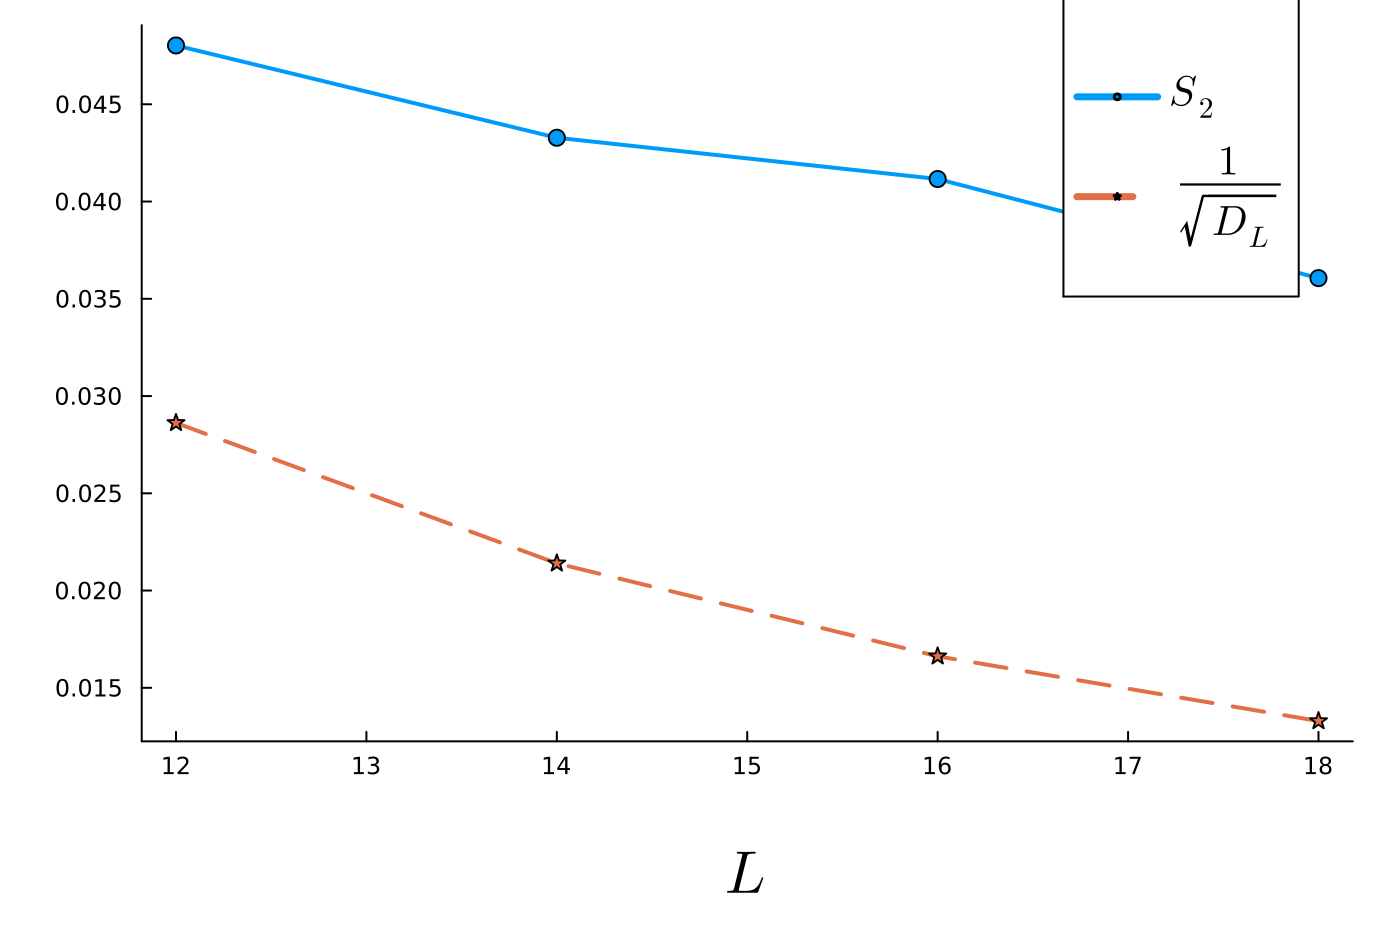

In [5]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

plot_size = (700,466.67)

inv_root_H_size_list = 1 ./sqrt.(H_size_list)

p = plot(N_list,avg_mat_elem_list,m=:circle,ms=4.5,msw=1,msc=:black,
              lw=2,ls=:solid,label="\$S_{$n}\$",size=plot_size,dpi=200)
plot!(N_list,inv_root_H_size_list,m=:star,ms=4.5,msw=1,msc=:black,lw=2,ls=:dash,label="\$\\frac{1}{\\sqrt{D_L}}\$")
# plot!(N_list,std_mat_elem_list,m=:circle,ms=4.5,msw=1,msc=:navy,lw=2,ls=:solid,label="\$\\mathrm{std}\$")

plot!(left_margin=5mm,right_margin=4mm,top_margin=1.2mm,bottom_margin=6mm)
plot!(framestyle=:axis)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)
plot!(legend_position=(0.85,0.9),legendfontsize=14,legend_background_color=:white,
    legend_foreground_color=:black,legend_columns=1)

xlabel!("\n\$L\$",guidefontsize=20)
# ylabel!("\$|\\langle n^{(0)}|H_p|S_{$n}\\rangle|\$\n",guidefontsize=20)
# title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = -4,2,4
y1,y_step,y2 = 0.0,0.5,1.5
xticks = (x1:x_step:x2,[@sprintf("%.1f",x) for x in x1:x_step:x2])
yticks = (y1:y_step:y2,[@sprintf("%.2f",y) for y in y1:y_step:y2])
xminor_ticks = 4
yminor_ticks = 2
# plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
#       xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:out)
# plot!(xlims=(-0.1,0.1))

# folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)\\scar_perturbation_matrix_element"
# if !isdir(folder_name)
#     mkpath(folder_name)
# end

# file_path = joinpath(folder_name,"Sn=$(n)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)